In [10]:
%load_ext autoreload
%autoreload 2

import transformers
import pdb
import wandb
import torch
from torch import nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import evaluate
from tqdm.auto import tqdm
from pathlib import Path
from torch.utils.data import DataLoader
from torchvision.io import read_image
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import random_split
from torchvision import datasets, models, transforms
from torch.utils.data import WeightedRandomSampler
from sklearn.utils.class_weight import compute_class_weight
from PIL import Image

from src.dataset import NAIPImagery
from src.config import Config
from src.sampler import BalancedBatchSampler
from src.prompts import prompting

from transformers import (
    VisionTextDualEncoderModel,
    VisionTextDualEncoderProcessor,
    AutoTokenizer,
    AutoImageProcessor
)

# Take care of cuda
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True

# Do config
#config =  Config("config_prompts.yaml")
#config_train = config.train_config

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Evaluate the CLIP-esque results

In [3]:
def calculate_metrics(labs, preds):
    
    metrics = {}
    accuracy_metric = evaluate.load("accuracy")
    f1_metric = evaluate.load("f1")
    acc = accuracy_metric.compute(references=labs, predictions=preds)
    f1 = f1_metric.compute(references=labs, predictions=preds, average="weighted")
    
    metrics.update(acc)
    metrics.update(f1)
    
    return metrics

def evaluate_dual_enc_df(df, processor, model):
    """ Process evaluation for a test DataFrame
    """
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    # Do evaluation for each example
    real_labels = []
    predict_label = []
    for idx, row in tqdm(df.iterrows(), total=df.shape[0], 
                         desc="Evaluating each pair img/text",
                         position=0
                        ):
        #original_caption = row.caption_column.rstrip()
        label = int(row["label"])
        real_labels.append(label)


        # if row["label"] == "1":
        #     real_caption = f"{original_caption}. This house is burned"
        #     fake_caption = f"{original_caption}. This house is not burned"
        # elif row["label"] == "0":
        #     real_caption = f"{original_caption}. This house is not burned"
        #     fake_caption = f"{original_caption}. This house is burned"
        # else:
        #     pass
        real_caption = row["caption_column"]
                            
        if label == 0:
            fake_label = "burned"
        elif label == 1:
            fake_label = "not burned"

        fake_caption = f"{real_caption.rsplit(' ', 1)[0]} {fake_label}"
        
        # Now open images and pass the same image for the two prompts
        images = [Image.open(row["image_column"]) for _ in range(2)]
        inputs = processor(text = [real_caption, fake_caption], images=images, return_tensors="pt", padding=True)
        inputs = {k: v.to(device) for k, v in inputs.items()}
        
        # Do model inference\
        model = model.to(device)
        outputs = model(**inputs)
        logits_per_image = outputs.logits_per_image  
        probs = logits_per_image.softmax(dim=1) 
        
        # Calculate predicted label
        arr = probs.cpu().detach().numpy()
        arr = np.diag(arr)
        
        win = np.argmax(arr,axis=0)
        if win == 0:
            pred = label
        else:
            pred = 1 - label
        
        predict_label.append(pred)
        
    return real_labels, predict_label
    

def evaluate_dual_enc_model(path_to_test,
                            path_to_model,
                            name_text,
                            name_vision,
                            k=100,
                            do_checkpoints=False
                           ):
    
    
    # Instantiate model and processor
    tokenizer = AutoTokenizer.from_pretrained(name_text)
    image_processor = AutoImageProcessor.from_pretrained(name_vision)
    processor = VisionTextDualEncoderProcessor(image_processor, tokenizer)
    
    model =  VisionTextDualEncoderModel.from_pretrained(path_to_model)
    
    # Read in text data
    test_data = pd.read_csv(path_to_test)
    
    # Calculate labels and sample using class weights
    test_data["label"] = test_data.image_column.apply(lambda x: x.split("_")[-1].split(".")[0])

    weights = compute_class_weight("balanced", classes=np.array([0, 1]), y=test_data.label.astype(int))
    weights_col = np.where(np.array(test_data["label"].astype(int)) == 0, weights[0], weights[1])
    test_data["weights"] = weights_col
    
    sample_df = test_data.sample(k, weights="weights", replace=True)
    
    
    if do_checkpoints:
        checkpoints = list(Path(path_to_model).rglob("checkpoint*"))
        num_checkpoints = [str(ls).split("-")[-1] for ls in checkpoints]
        
        metrics_list = []
        for check, epoch in tqdm(zip(checkpoints, num_checkpoints), desc="Processing for each checkpoint",
                                position=1, leave=False):
            model = VisionTextDualEncoderModel.from_pretrained(check)
            labs, preds = evaluate_dual_enc_df(sample_df, processor, model)
            metrics = calculate_metrics(labs, preds)
            
            metrics.update({"epoch": int(epoch)})
            
            metrics_list.append(metrics)
        
        return metrics_list
            
    
    else:
        labs, preds = evaluate_dual_enc_df(sample_df, processor, model)
        metrics = calculate_metrics(labs, preds)
        
        return metrics

### Run evaluation on single model

In [13]:
metrics = evaluate_dual_enc_model(path_to_test="data/test_data.csv",  
                                      name_text="roberta-base",
                                      name_vision="google/vit-base-patch16-224",
                                      path_to_model="/mnt/sherlock/scratch/vit-roberta-finetuned-supervised-small-k/checkpoint-3288/",
                                      k=2000,
                                      do_checkpoints=False
                                     )

Evaluating each pair img/text: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [02:54<00:00, 11.43it/s]


In [14]:
metrics

{'accuracy': 0.751, 'f1': 0.7355780900214338}

## Run evaluation on all models

In [295]:
name_text_list = ["roberta-base", "bert-base-uncased", "roberta-base"]
name_vision_list = ["google/vit-base-patch16-224", "google/vit-base-patch16-224", "openai/clip-vit-base-patch32"]
model_paths = ["./vit-roberta-finetuned/", "vit-gpt2-finetuned/", "./clip-roberta-finetuned-correct/"]


df_list = []
for name_text, name_vision, model_path in zip(name_text_list, name_vision_list, model_paths):
    print(f"{name_text} and {name_vision}")
    metrics = evaluate_dual_enc_model(path_to_test="test_data.csv",  
                                      name_text=name_text,
                                      name_vision=name_vision,
                                      path_to_model=model_path,
                                      k=100,
                                      do_checkpoints=True
                                     )
    metrics_df = pd.DataFrame(metrics)
    metrics_df = metrics_df.assign(vision_model = name_vision, 
                                   model_paths = Path(model_path).stem,
                                   text_model = name_text)
    df_list.append(metrics_df)

roberta-base and google/vit-base-patch16-224



Evaluating each pair img/text: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 11.04it/s]

Evaluating each pair img/text: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 11.26it/s]

Evaluating each pair img/text: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████

bert-base-uncased and google/vit-base-patch16-224



Evaluating each pair img/text: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.53it/s]

Evaluating each pair img/text: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.78it/s]

Evaluating each pair img/text: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████

roberta-base and openai/clip-vit-base-patch32


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.

Evaluating each pair img/text: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 16.26it/s]

Evaluating each pair img/text: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/1

In [297]:
all_metrics = pd.concat(df_list)
all_metrics

,accuracy,f1,epoch,vision_model,model_paths,text_model
0,0.61,0.609566,4500,google/vit-base-patch16-224,vit-roberta-finetuned,roberta-base
1,0.53,0.521897,1000,google/vit-base-patch16-224,vit-roberta-finetuned,roberta-base
2,0.69,0.677600,4000,google/vit-base-patch16-224,vit-roberta-finetuned,roberta-base
3,0.54,0.527238,3000,google/vit-base-patch16-224,vit-roberta-finetuned,roberta-base
4,0.54,0.540000,3500,google/vit-base-patch16-224,vit-roberta-finetuned,roberta-base
5,0.63,0.630778,2000,google/vit-base-patch16-224,vit-roberta-finetuned,roberta-base
6,0.61,0.607008,2500,google/vit-base-patch16-224,vit-roberta-finetuned,roberta-base
7,0.62,0.616256,5000,google/vit-base-patch16-224,vit-roberta-finetuned,roberta-base
8,0.58,0.580000,1500,google/vit-base-patch16-224,vit-roberta-finetuned,roberta-base
9,0.54,0.503922,500,google/vit-base-patch16-224,vit-roberta-finetuned,roberta-base


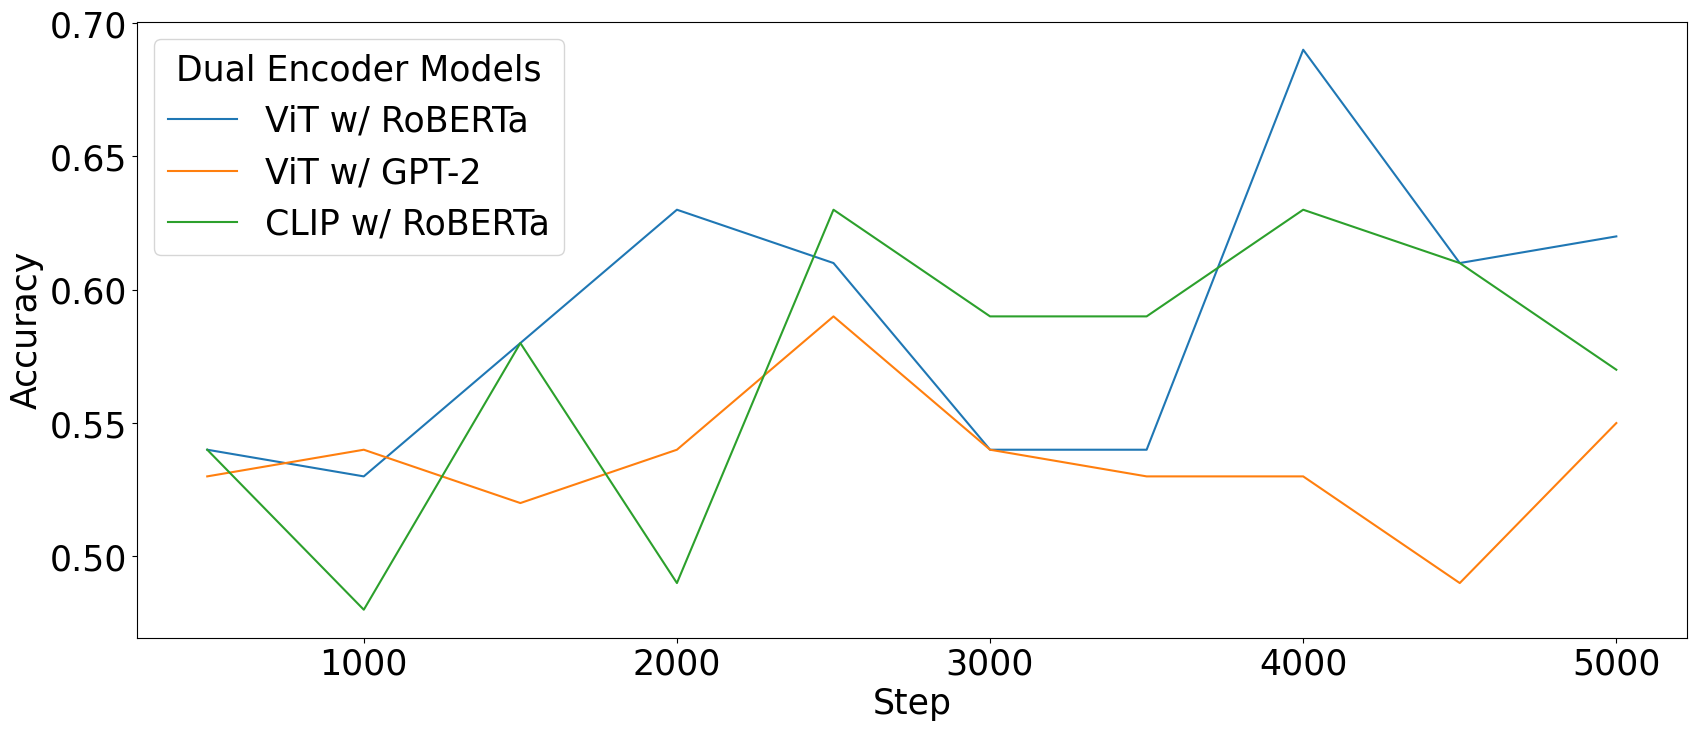

In [339]:
import seaborn as sns
import matplotlib
matplotlib.rcParams.update({'font.size': 25})

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(20, 8))
g = sns.lineplot(x = "epoch", y = "accuracy", hue="model_paths", data = all_metrics, ax=ax)
ax.set(xlabel = "Step", ylabel = "Accuracy")


# change legend texts
new_title = "Dual Encoder Models"
g.legend_.set_title(new_title)
new_labels = ['ViT w/ RoBERTa', 'ViT w/ GPT-2', 'CLIP w/ RoBERTa']
for t, l in zip(g.legend_.texts, new_labels):
    t.set_text(l)
plt.savefig("accuracy_clip_models.png", dpi=150)

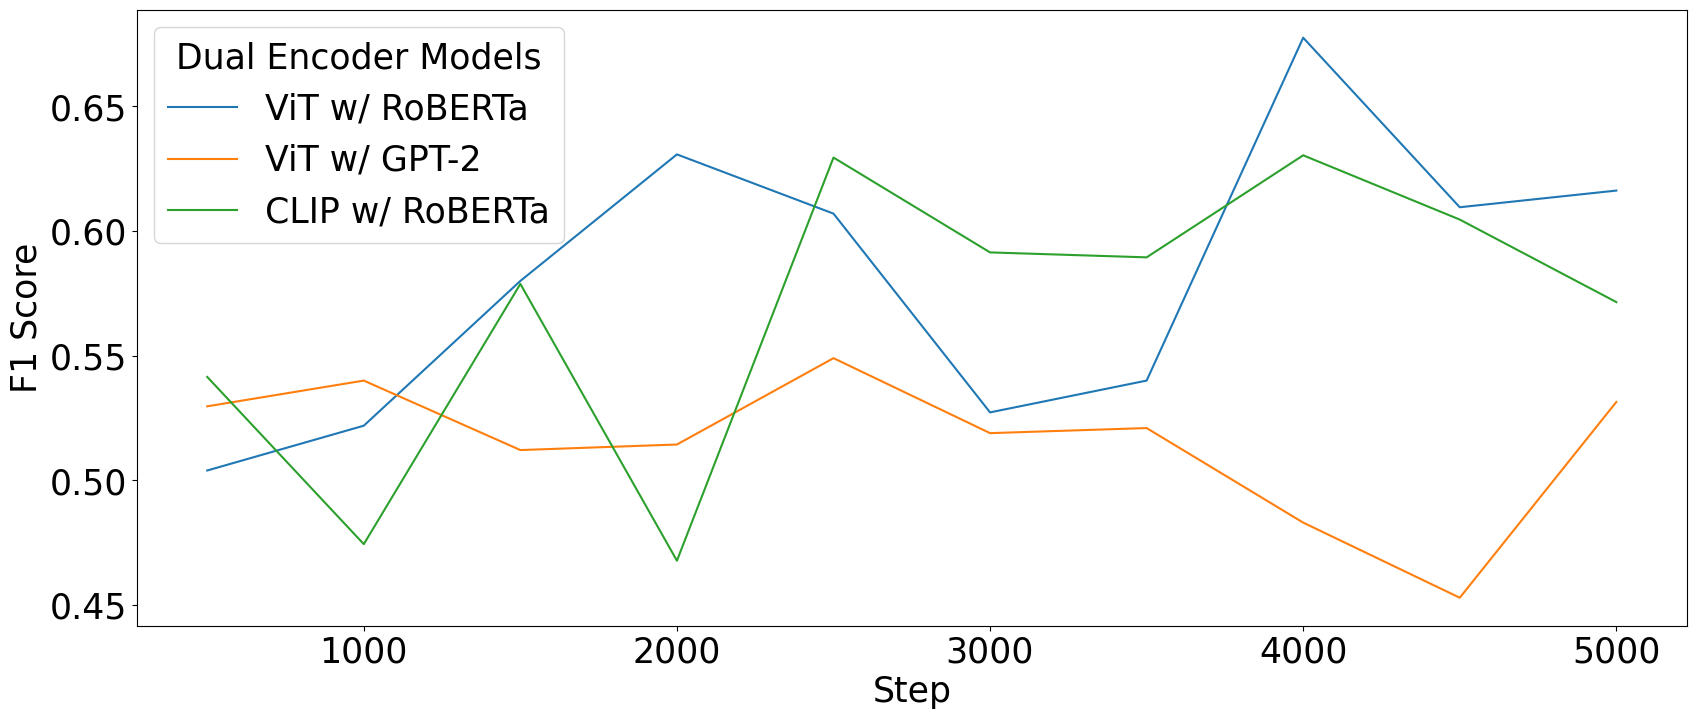

In [341]:
fig, ax = plt.subplots(figsize=(20, 8))
g = sns.lineplot(x = "epoch", y = "f1", hue="model_paths", data = all_metrics, ax=ax)
ax.set(xlabel = "Step", ylabel = "F1 Score")


# change legend texts
new_title = "Dual Encoder Models"
g.legend_.set_title(new_title)
new_labels = ['ViT w/ RoBERTa', 'ViT w/ GPT-2', 'CLIP w/ RoBERTa']
for t, l in zip(g.legend_.texts, new_labels):
    t.set_text(l)
plt.savefig("f1_clip_models.png", dpi=150)